In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from numba import jit

In [2]:
data = np.loadtxt('TSPA.csv', delimiter=';').astype(np.int16)
data.shape

(200, 3)

In [3]:
def distance(xa, ya, xb, yb):
    return round(((xa-xb)**2+(ya-yb)**2)**(1/2))
distance(1,2,4,5)

4

In [4]:
def create_cost_matrix(data):
    distance_matrix = np.empty((0,len(data)), int)
    for i in range(len(data)):
        row = []
        for j in range(len(data)):
            if i != j:
                row.append(distance(data[i][0], data[i][1], data[j][0], data[j][1]))
            else:
                row.append(0)
        distance_matrix = np.append(distance_matrix, [row], axis=0)

    costs = data[:,2]
    #print(distance_matrix)
    cost_matrix = (distance_matrix + costs)
    return cost_matrix

cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

In [5]:
cost_matrix

array([[  84, 2032, 2098, ..., 4159, 3783, 1514],
       [1633,  483, 2398, ..., 3349, 2266,  817],
       [ 720, 1419, 1462, ..., 3640, 3149,  964],
       ...,
       [2782, 2371, 3641, ..., 1461, 2908, 2554],
       [2558, 1440, 3302, ..., 3060, 1309, 1773],
       [1234,  936, 2062, ..., 3651, 2718,  364]])

In [6]:
def random_solution(cost_matrix, limit=100):
    random_solution_list = list(range(0,len(cost_matrix)))
    random.shuffle(random_solution_list)
    return np.array(random_solution_list)[:limit]

solution = random_solution(cost_matrix, 100)
print(solution)

[127 195  93  17 145 120  61 129   8  21   1 169  39 118 178  36 194  73
   9 108  78  40  48  32 190 175   6  58 186 153  15 163 157  11 128 151
 158 189  81  90 109   0  88 126 165 142  85  20 123  31 146  75 154 196
 140 162  37 132 185 160  18  51  74   5  95 138 174 106  34 147 121  68
  97  56  24 184   4  14  62 150 136 117  66 166 155 187 102  60  84 137
  10 115 161  47 159 139  49  86  45   3]


In [7]:
def calculate_objective_function(solution, cost_matrix):
    obj_func = 0
    for i in range(len(solution)-1):
        obj_func += cost_matrix[solution[i], solution[i+1]]
    obj_func += cost_matrix[solution[0], solution[-1]]
    return obj_func

calculate_objective_function(solution, cost_matrix)

262538

In [8]:
def nearest_neighbour(cost_matrix, current_id=random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    while len(solution) < limit:
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    return np.array(solution)

solution = nearest_neighbour(cost_matrix)
print(calculate_objective_function(solution, cost_matrix))

87340


In [48]:
def greedy_cycle(cost_matrix, current_id = random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    for _ in range(1):
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    
    while len(solution) < limit:
        min_delta = 99999
        min_id = -1
        insert_id = -1
        for i in range(len(solution)-1):
            for next_id in all_ids:
                delta = cost_matrix[solution[i]][next_id] + cost_matrix[next_id][solution[i+1]] - cost_matrix[solution[i]][solution[i+1]]
                if delta < min_delta:
                    min_delta = delta
                    min_id = next_id
                    insert_id = i
        for next_id in all_ids:
            delta = cost_matrix[solution[-1]][next_id] + cost_matrix[next_id][solution[0]] - cost_matrix[solution[-1]][solution[0]]
            if delta < min_delta:
                min_delta = delta
                min_id = next_id
                insert_id = i
        solution.insert(insert_id+1, min_id)
        all_ids.remove(min_id)
        print(min_delta, solution)

    return np.array(solution)
        

# solution = greedy_cycle(cost_matrix)
# print(calculate_objective_function(solution, cost_matrix))

===================================== <br> 
Use numba to accelerate functions (keep in mind that the first run will be slower due to compilation)

In [49]:
greedy_cycle_jit = jit()(greedy_cycle)

In [62]:
new_cycle = greedy_cycle_jit(cost_matrix, 0, 10)
new_cycle

575 [0, 178, 19]
554 [0, 164, 178, 19]
602 [0, 164, 178, 149, 19]
915 [0, 128, 164, 178, 149, 19]
704 [0, 132, 128, 164, 178, 149, 19]
614 [0, 55, 132, 128, 164, 178, 149, 19]
432 [0, 55, 195, 132, 128, 164, 178, 149, 19]
442 [0, 55, 22, 195, 132, 128, 164, 178, 149, 19]


array([  0,  55,  22, 195, 132, 128, 164, 178, 149,  19])

In [58]:
cost_matrix[55, 195]

391

In [59]:
cost_matrix[195, 132] 

826

In [60]:
cost_matrix[55, 132]

785

In [38]:
cost_matrix[[  0, 178,  19]][:, [  0, 178,  19]]

array([[ 84, 547, 447],
       [600,  31, 475],
       [381, 356, 150]])

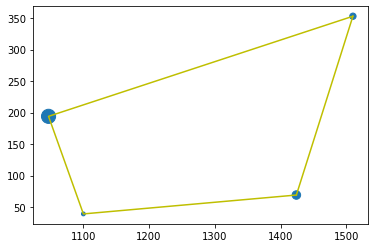

In [35]:
plot(data, new_cycle)

In [11]:
nearest_neighbour_jit = jit()(nearest_neighbour)

=====================================

In [12]:
def test_solver(solver, cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for i in range(n):
        solution = solver(cost_matrix, i)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [13]:
def test_random_solver(cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for _ in range(n):
        solution = random_solution(cost_matrix)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [14]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200)
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

RANDOM SOLUTION
AVERAGE: 265076.48
MINIMUM (BEST): 230124
MAXIMUM (WORST): 297007


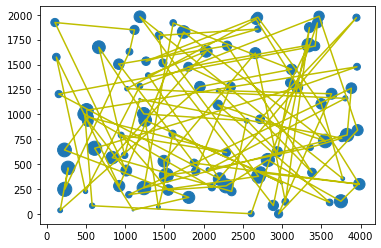

In [15]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 87741.23
MINIMUM (BEST): 84840
MAXIMUM (WORST): 95932


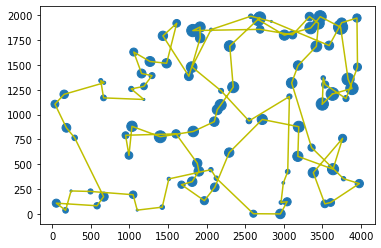

In [16]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 76387.4
MINIMUM (BEST): 74573
MAXIMUM (WORST): 79158


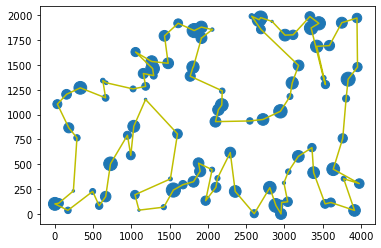

In [18]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

GREEDY CYCLE
AVERAGE: 76387.4
MINIMUM (BEST): 74573
MAXIMUM (WORST): 79158


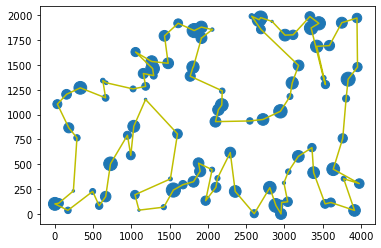

In [18]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

### Greedy cycle with and without jit

In [ ]:
greedy_cycle_jit()

In [17]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)

In [ ]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)

1min 20s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Nearest Neighbour with and without jit

In [22]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)

15 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(nearest_neighbour, cost_matrix, 200)

516 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


=================================

In [21]:
data = np.loadtxt('TSPB.csv', delimiter=';').astype(np.int16)
cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

RANDOM SOLUTION
AVERAGE: 265537.55
MINIMUM (BEST): 238404
MAXIMUM (WORST): 294227


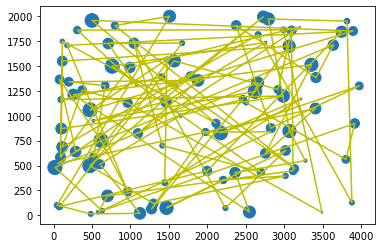

In [22]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 79096.295
MINIMUM (BEST): 77417
MAXIMUM (WORST): 81600


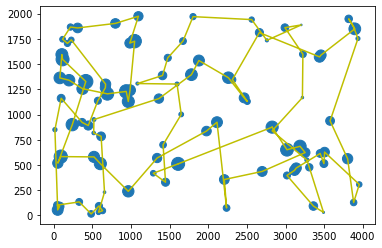

In [23]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

NEAREST NEIGHBOR
AVERAGE: 79096.295
MINIMUM (BEST): 77417
MAXIMUM (WORST): 81600


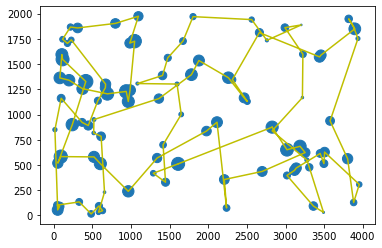

In [24]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 69961.23
MINIMUM (BEST): 67684
MAXIMUM (WORST): 75068


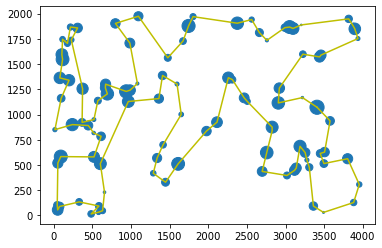

In [25]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

GREEDY CYCLE
AVERAGE: 69961.23
MINIMUM (BEST): 67684
MAXIMUM (WORST): 75068


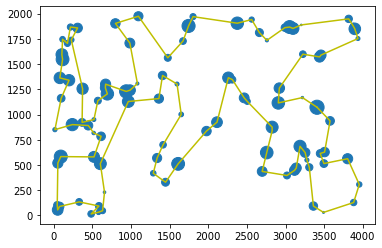

In [26]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)